In [1]:
import pandas as pd
import numpy as np

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['image.cmap'] = 'hot_r'
from matplotlib.colors import LogNorm

#import seaborn as sns

from scipy.optimize import curve_fit
from scipy.stats import iqr
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.stats import norm

%matplotlib inline

In [2]:
def tw_func(x, a, b, c, d):
    return a*x + b + c / (x - d)

# Load Si channels

In [3]:
fname = 'calib/all_timing_test_runs_310_350.h5'

In [4]:
df = pd.read_hdf(fname, '/table')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1991192 entries, 310000001.0 to 350010062.0
Data columns (total 16 columns):
rechit_chip_id         int32
rechit_channel         int32
rechit_energy          float32
rechit_Tot             int16
rechit_amplitudeLow    float32
rechit_timeMaxLG       float32
rechit_toaRise         int16
rechit_toaFall         int16
run                    int64
loc_event              int64
rechit_chan_id         int32
rechit_layer           int32
rechit_toaRise_norm    float64
rechit_toaFall_norm    float64
toa_rise_time          float64
toa_fall_time          float64
dtypes: float32(3), float64(4), int16(3), int32(4), int64(2)
memory usage: 170.9 MB


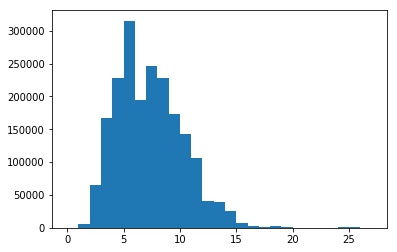

In [6]:
plt.hist(df.rechit_layer, range(28))
plt.show()

In [7]:
df.head()

rechit_chip_id  rechit_channel  rechit_energy  rechit_Tot  \
event                                                                    
310000001.0              11              32      34.638416           4   
310000001.0              12              18      31.096622           4   
310000001.0              16              26      52.683369           4   
310000001.0              20              14      33.777824           4   
310000001.0              21              44      31.421846           4   

             rechit_amplitudeLow  rechit_timeMaxLG  rechit_toaRise  \
event                                                                
310000001.0            171.03125         44.242188            1505   
310000001.0            176.34375         44.593750            1434   
310000001.0            327.43750         42.921875            1854   
310000001.0            209.71875         43.265625            1605   
310000001.0            193.71875         44.796875            1550   

             rechit_toaFall  run  loc_event  rechit_chan_id  rechit_layer  \
event                                                                       
310000001.0            2402  310          1             736             2   
310000001.0            2332  310          1             786             3   
310000001.0            2636  310          1            1050             4   
310000001.0            2470  310          1            1294             5   
310000001.0            2512  310          1            1388             5   

             rechit_toaRise_norm  rechit_toaFall_norm  toa_rise_time  \
event                                                                  
310000001.0             0.232885             0.802453       4.044507   
310000001.0             0.189677             0.767834       3.057324   
310000001.0             0.404821             0.885998       7.317321   
310000001.0             0.273300             0.818239       4.953113   
310000001.0             0.196790             0.771700       3.601019   

             toa_fall_time  
event                       
310000001.0      15.559356  
310000001.0      15.202899  
310000001.0      19.397497  
310000001.0      16.524754  
310000001.0      15.282947

## Load time ref

In [8]:
%%time
columns = [u'rechit_chip_id', 'run', u'rechit_channel', 'toa_rise_time', 'toa_fall_time']
#tref_fname = './time_layer_test.h5'
#tref_fname = 'timeref/time_layer_test_runs_240_263.h5'
#tref_fname = 'timeref/time_layer_test_runs_310_350.h5'
tref_fname = 'timeref/test.h5'
df_tref = pd.read_hdf(tref_fname, columns = columns, key='/table')

CPU times: user 3.23 s, sys: 1.87 s, total: 5.1 s
Wall time: 6.77 s


In [9]:
#### HACK
#df_tref.toa_rise_time = 25 - df_tref.toa_rise_time

### Extract single ref channel

In [10]:
##Create df for single reference channel 

ref_layer = 29

ref_chip = 4*ref_layer + 2
ref_chan = 38

sel = df_tref.toa_rise_time > 0
sel &= df_tref.rechit_chip_id == ref_chip
sel &= df_tref.rechit_channel == ref_chan

cols = ['run', 'toa_rise_time', 'toa_fall_time']
df_tref_ch = df_tref[sel][cols]

### Merge dfs

In [11]:
%%time
df_join = df.join(df_tref_ch, lsuffix='', rsuffix='_ref', how='inner')

CPU times: user 2.17 s, sys: 368 ms, total: 2.54 s
Wall time: 2.99 s


In [12]:
df_join[df_join.rechit_energy > 200].head()

rechit_chip_id  rechit_channel  rechit_energy  rechit_Tot  \
event                                                                    
310000013.0              26              30     229.309113         494   
310000471.0              32              20     265.223480         425   
310000519.0              26              24     204.573257         502   
310000556.0              26               2     226.983322         491   
310000807.0              30              52     209.116501         360   

             rechit_amplitudeLow  rechit_timeMaxLG  rechit_toaRise  \
event                                                                
310000013.0             1179.000         37.039062            2511   
310000471.0             1273.750         40.242188            2185   
310000519.0             1087.500         42.250000            2122   
310000556.0             1147.250         41.671875            2187   
310000807.0              982.625         31.015625            2566   

             rechit_toaFall  run  loc_event  rechit_chan_id  rechit_layer  \
event                                                                       
310000013.0            1762  310         13            1694             6   
310000471.0            1265  310        471            2068             8   
310000519.0            2648  310        519            1688             6   
310000556.0            1197  310        556            1666             6   
310000807.0            2031  310        807            1972             7   

             rechit_toaRise_norm  rechit_toaFall_norm  toa_rise_time  \
event                                                                  
310000013.0             0.897571             0.409299      19.669120   
310000471.0             0.750844             0.124577      15.081483   
310000519.0             0.647712             0.995446      12.574902   
310000556.0             0.694971             0.056420      13.900069   
310000807.0             0.995289             0.634459      24.318294   

             toa_fall_time  run_ref  toa_rise_time_ref  toa_fall_time_ref  
event                                                                      
310000013.0       6.807588      310          16.969158           4.253382  
310000471.0       2.168169      310          15.466203           2.687364  
310000519.0      24.860287      310          10.171374          22.348725  
310000556.0       0.815445      310          10.765075          23.046545  
310000807.0      11.758468      310          23.754782          11.603736

In [13]:
df_join['deltaT_ref'] = df_join.toa_rise_time - df_join.toa_rise_time_ref

In [14]:
plt.figure(figsize = (10,6))

sel = abs(df_join.deltaT_ref) < 80
sel &= df_join.rechit_energy > 20
# sel &= df_join.rechit_energy < 700

#sel &= df_join.rechit_channel == 36
sel &= df_join.rechit_layer == 8

#sel &= df_join.run < 380

dt = -(df_join.toa_fall_time - df_join.toa_fall_time_ref - 4 ) %25

plt.hist2d(df_join[sel].rechit_energy, dt[sel], bins = 100,  norm = LogNorm())

plt.colorbar()
plt.grid()

### Apply TW correction

In [15]:
tw_params = [7.1637896372901985e-25, 0.8499666270628335, 310.6501777092844, -3.069704644898795]

In [16]:
%%time
df_join['tw_corr'] = 0
df_join['tw_corr'] = df_join['rechit_energy'].apply(lambda x: tw_func(x, *tw_params))

CPU times: user 1.04 s, sys: 104 ms, total: 1.14 s
Wall time: 1.18 s


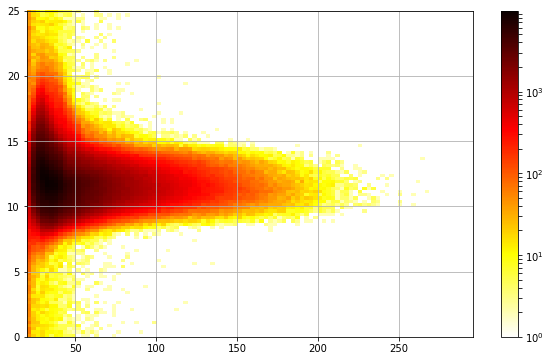

In [17]:
plt.figure(figsize = (10,6))

sel = abs(df_join.deltaT_ref) < 80
sel &= df_join.rechit_energy > 20
sel &= df_join.rechit_energy < 300

#sel &= df_join.rechit_channel == 36
#sel &= df_join.rechit_layer == 8


dt = -(df_join.toa_fall_time - df_join.toa_fall_time_ref + df_join.tw_corr + 10) %25

plt.hist2d(df_join[sel].rechit_energy, dt[sel], bins = 100,  norm = LogNorm())

plt.colorbar()
plt.grid()

In [18]:
df_join['dt'] = -(df_join.toa_fall_time - df_join.toa_fall_time_ref + df_join.tw_corr + 10) %25 - 11

In [19]:
df_join.columns

Index([u'rechit_chip_id', u'rechit_channel', u'rechit_energy', u'rechit_Tot',
       u'rechit_amplitudeLow', u'rechit_timeMaxLG', u'rechit_toaRise',
       u'rechit_toaFall', u'run', u'loc_event', u'rechit_chan_id',
       u'rechit_layer', u'rechit_toaRise_norm', u'rechit_toaFall_norm',
       u'toa_rise_time', u'toa_fall_time', u'run_ref', u'toa_rise_time_ref',
       u'toa_fall_time_ref', u'deltaT_ref', u'tw_corr', u'dt'],
      dtype='object')

In [20]:
sel = abs(df_join.dt) < 5
sel &= df_join.rechit_energy > 70
sel &= df_join.rechit_energy < 200

#sel &= df_join.rechit_channel == 36
sel &= df_join.rechit_layer == 8

plt.hist2d(df_join.rechit_chip_id[sel], df_join.dt[sel],100)

plt.show()

### Offsets to Tref

In [21]:
sel = abs(df_join.rechit_energy - 100) < 5
sel &= abs(df_join['dt']) < 5

offs = df_join[sel].groupby('rechit_chan_id')['dt'].median()

In [22]:
df_offs = pd.DataFrame(offs)
df_offs.reset_index(inplace = True)
df_offs['chan_id'] = df_offs.rechit_chan_id%64
df_offs['chip_id'] = (df_offs.rechit_chan_id - df_offs.chan_id)/64
df_offs['chip'] = df_offs.chip_id%4
df_offs['layer'] = df_offs.chip_id//4

In [23]:
df_offs.head()

rechit_chan_id        dt  chan_id  chip_id  chip  layer
0             278  3.465813       22      4.0   0.0    1.0
1             286  1.706101       30      4.0   0.0    1.0
2             424  0.354385       40      6.0   2.0    1.0
3             530  1.917498       18      8.0   0.0    2.0
4             532  0.521804       20      8.0   0.0    2.0

In [24]:
plt.plot(df_offs.layer, df_offs.dt, 'o')

In [25]:
plt.hist2d(df_offs.layer, df_offs.dt, (range(20),50))
plt.show()

In [26]:
import seaborn as sns

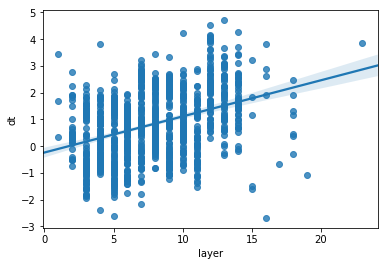

In [27]:
sns.regplot(df_offs.layer, df_offs.dt, (range(20),50))

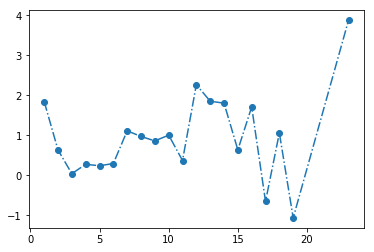

In [28]:
plt.plot(df_offs.groupby('layer')['dt'].mean(), 'o-.')

In [29]:
for lay in range(5,15):

    sel = df_offs.layer == lay
    plt.plot(df_offs[sel].groupby('chip')['dt'].mean(), 'o-.', label = str(lay))
    
plt.legend()

In [30]:
chip_offs = df_offs.groupby('chip')['dt'].mean()
#chip_offs -= chip_offs.mean()

In [31]:
df_offs['dt_chipcorr'] = 0#df_offs.dt.copy()

for chip in range(4):
    sel = df_offs.chip == chip
    df_offs.loc[sel,'dt_chipcorr'] = df_offs.loc[sel,'dt'] - chip_offs[chip]

In [32]:
plt.plot(df_offs.groupby('chip')['dt_chipcorr'].mean(), 'o-.')

In [33]:
plt.plot(df_offs.groupby('layer')['dt'].mean(), 'o-.')
plt.plot(df_offs.groupby('layer')['dt_chipcorr'].mean(), 'o-.')

In [34]:
for lay in range(5,13,2):

    sel = df_offs.layer == lay
    sel &= df_offs.chip == 2

    plt.plot(df_offs[sel].groupby('chan_id')['dt'].mean(), 'o-.', label = str(lay))
    
plt.legend()

In [35]:
df_join['ref_offset'] = 0
df_join['ref_offset'] = df_join['rechit_chan_id'].map(offs.to_dict())

In [144]:
df_join['rise_time_corr'] = df_join['toa_rise_time'] - df_join['ref_offset'] 

In [145]:
df['ref_offset'] = 0
df['ref_offset'] = df['rechit_chan_id'].map(offs.to_dict())

In [154]:
df['rise_time_corr'] = df['toa_rise_time'] + df['ref_offset'] 

## Time walk

In [36]:
def tw_func(x, a, b, c, d):
    return a*x + b + c / (x - d)

In [37]:
def stitched_tw_profile(x,y, bins1 = 100, bins2 = 100, y_sep = 5):
    
    ### dt vs X
    x_mean1,y_mean1 = binned_statistic(x, [x,y], bins=bins1, statistic='median').statistic
    x_err1,y_err1 = binned_statistic(x, [x,y], bins=bins1, statistic=iqr).statistic / 1.35

    ### X vs dt
    x_mean2,y_mean2 = binned_statistic(y, [x,y], bins=bins2, statistic='median').statistic
    x_err2,y_err2 = binned_statistic(y, [x,y], bins=bins2, statistic=iqr).statistic / 1.35
    
    nan_idxs = np.isnan(x_mean1 * y_mean1 * y_err1)
    x_mean1 = x_mean1[~nan_idxs]; y_mean1 = y_mean1[~nan_idxs]; y_err1 = y_err1[~nan_idxs]

    #sel1 = x_mean1 >= x_sep; #sel1 &= x_mean1 < 300
    sel1 = y_mean1 < y_sep
    sel1 &= y_mean1 > 0
    #sel1 &= y_mean1 < 15

    nan_idxs = np.isnan(x_mean2 * y_mean2 * y_err2)
    x_mean2 = x_mean2[~nan_idxs]; y_mean2 = y_mean2[~nan_idxs]; y_err2 = y_err2[~nan_idxs]

    #sel2 = x_mean2 < x_sep; #sel2 &= x_mean2 < 600
    sel2 = y_mean2 >= y_sep
    sel2 &= y_mean2 > 0
    #sel2 &= y_mean2 < 15

    x_comb = np.append(x_mean1[sel1], x_mean2[sel2])
    y_comb = np.append(y_mean1[sel1], y_mean2[sel2])

    y_comb_err = np.append(y_err1[sel1], y_err2[sel2])

    sort_idx = x_comb.argsort()
    x_comb = x_comb[sort_idx]
    y_comb = y_comb[sort_idx]
    y_comb_err = y_comb_err[sort_idx]

    return x_comb, y_comb, y_comb_err

In [38]:
%%time
plt.figure(figsize = (10,6))

sel = abs(df_join.dt) < 25
sel &= df_join.rechit_energy > 20

sel &= df_join.rechit_channel == 36
sel &= df_join.rechit_layer > 5
sel &= df_join.rechit_layer < 10
#sel &= df_join.rechit_chip_id%4 == 2

df_sel = df_join[sel]
chips = np.sort(df_sel.rechit_chip_id.unique())

## x = energy
bins1 = np.logspace(np.log10(20),np.log10(600),100)
#bins1 = np.linspace(20,800,150)
xval = 'rechit_energy'

## x = LG
# bins1 = np.logspace(np.log10(100),np.log10(2000),100)
# xval = 'rechit_amplitudeLow'

## y
bins2 = np.linspace(0,17,50)
yval = 'deltaT_ref'


for chip in chips:#[:5]:
    chan_sel = df_sel.rechit_chip_id == chip
    
    nhits = np.count_nonzero(chan_sel)
    print chip, nhits,
    
    if nhits < 1000: continue

    x = df_sel[chan_sel][xval]
    y = -(df_sel[chan_sel][yval] + df_sel[chan_sel].ref_offset - 4)%25
    
    x_mean, y_mean, y_err = stitched_tw_profile(x,y,bins1,bins2, 5)
    plt.plot(x_mean, y_mean, '.', label = str(chip))#, mfc = 'none')
    
    sel = y_mean < 8
    tw_params, pcov = curve_fit(tw_func, x_mean[sel], y_mean[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )
    
    print tw_params
    
tw_params = tw_params.tolist()
xs = np.linspace(30,600)
plt.plot(xs,tw_func(xs,*tw_params), 'b--')
    
plt.legend()
plt.grid()

24 132 25 4589 [ 4.69877990e-21 -8.33153205e-01  4.10653421e+02  5.52663349e+00]
26 6842 [8.59970165e-22 2.45712184e-01 3.05480905e+02 3.40464297e+00]
27 6469 [9.31626899e-20 5.31067111e-01 3.05405726e+02 1.16262360e+00]
28 174 29 6425 [ 1.50748524e-18  3.20800485e-01  3.35525933e+02 -3.11016491e+00]
30 9358 [ 2.12585256e-19  1.22545504e-01  3.12645561e+02 -2.16724887e+00]
31 5829 [ 2.83717321e-23  4.23824027e-01  3.08716066e+02 -1.61883939e+00]
32 130 33 6880 [ 3.39276779e-03 -3.44317451e-01  3.73683888e+02 -8.97960824e+00]
34 8248 [ 3.81584252e-03 -6.91264688e-03  3.25663030e+02 -7.02786267e+00]
35 7051 [2.05857362e-04 1.37515457e+00 1.57498196e+02 1.66078098e+01]
36 117 37 5957 [3.03195610e-04 5.93328456e-01 3.12053689e+02 7.99552985e-01]
38 6702 [ 4.07771745e-03  7.19247734e-02  3.88943549e+02 -6.43501856e+00]
39 5674 [ 1.08178884e-14  1.02586424e-01  3.41296315e+02 -3.74880129e+00]
CPU times: user 1.63 s, sys: 229 ms, total: 1.86 s
Wall time: 2.03 s


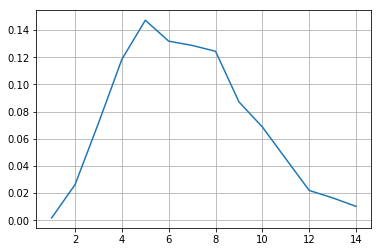

In [114]:
sel = df.rechit_layer < 15
plt.plot(df[sel].groupby(['rechit_layer'])['rechit_energy'].sum() / df[sel]['rechit_energy'].sum())
plt.grid()

In [186]:
d_lays = {}

sel = df.rechit_energy > 40

d_lays['time'] = df[sel].groupby(['event'])['toa_rise_time'].mean()
d_lays['time_corr'] = df[sel].groupby(['event'])['rise_time_corr'].mean()
d_lays['ene'] = df[sel].groupby(['event'])['rechit_energy'].sum()
d_lays['nhits'] = df[sel].groupby(['event'])['toa_rise_time'].count()

tmeans = df[sel].groupby(['rechit_layer','event'])['toa_rise_time'].mean()
tmeans_corr = df[sel].groupby(['rechit_layer','event'])['rise_time_corr'].mean()

esums = df[sel].groupby(['rechit_layer','event'])['rechit_energy'].sum()
nhits = df[sel].groupby(['rechit_layer','event'])['rechit_energy'].count()

for layer in range(5,10):
    d_lays['time_l%i' %layer] = tmeans[layer]
    d_lays['time_corr_l%i' %layer] = tmeans_corr[layer]
    d_lays['ene_l%i' %layer] = esums[layer]
    d_lays['nhits_l%i' %layer] = nhits[layer]
    
df_lays = pd.DataFrame(d_lays)

In [188]:
df_lays.head()

ene     ene_l5      ene_l6      ene_l7      ene_l8  \
event                                                                    
310000001.0  825.911987  62.507778   77.148468  143.084335   93.609871   
310000002.0  626.061646  60.263641  119.147530   46.884357   90.801788   
310000003.0  322.007904  53.146076   43.912659   70.779602  105.547676   
310000005.0  209.805023        NaN   63.777565   60.168705   41.624260   
310000006.0  430.160522  65.363068   62.255676         NaN  107.084190   

                 ene_l9  nhits  nhits_l5  nhits_l6  nhits_l7    ...      \
event                                                           ...       
310000001.0   68.996071     12       1.0       1.0       2.0    ...       
310000002.0  105.904510     12       1.0       2.0       1.0    ...       
310000003.0   48.621899      5       1.0       1.0       1.0    ...       
310000005.0         NaN      4       NaN       1.0       1.0    ...       
310000006.0         NaN      7       1.0       1.0       NaN    ...       

             time_corr_l5  time_corr_l6  time_corr_l7  time_corr_l8  \
event                                                                 
310000001.0     10.114385      9.970516      9.845888     10.626655   
310000002.0     12.501031     11.826354     11.682115     10.765730   
310000003.0     22.715632     17.854269     23.632686     24.784384   
310000005.0           NaN     22.375909     21.969411     20.584094   
310000006.0      1.829331      1.617754           NaN     13.254091   

             time_corr_l9    time_l5    time_l6    time_l7    time_l8  \
event                                                                   
310000001.0      9.180131   8.535726   9.022562   7.191824   8.504122   
310000002.0     11.142386  11.454661  11.232448  10.289719   9.338567   
310000003.0     21.637039  22.979279  17.282242  23.015876  23.910664   
310000005.0           NaN        NaN  21.006848  19.769094  18.145466   
310000006.0           NaN   2.564330   1.946642        NaN  12.410195   

               time_l9  
event                   
310000001.0   7.158635  
310000002.0   8.969517  
310000003.0  21.823997  
310000005.0        NaN  
310000006.0        NaN  

[5 rows x 24 columns]

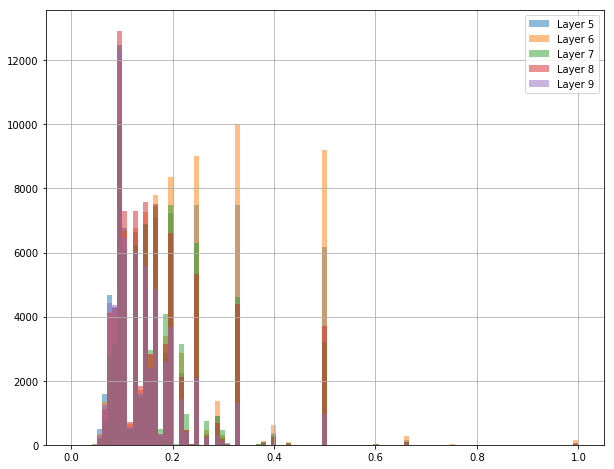

In [189]:
plt.figure(figsize = (10,8))

xbins = np.linspace(0,1,100)

for layer in range(5,10):
    
    label = 'nhits_l%i' %layer
    
    sel = df_lays[label] < 9
    sel &= df_lays.nhits > 1

    r = plt.hist((df_lays[label]/df_lays.nhits)[sel], xbins, label = 'Layer %i' %layer,
                 alpha = 0.5)
    
#plt.yscale('log')
plt.legend()
plt.grid()

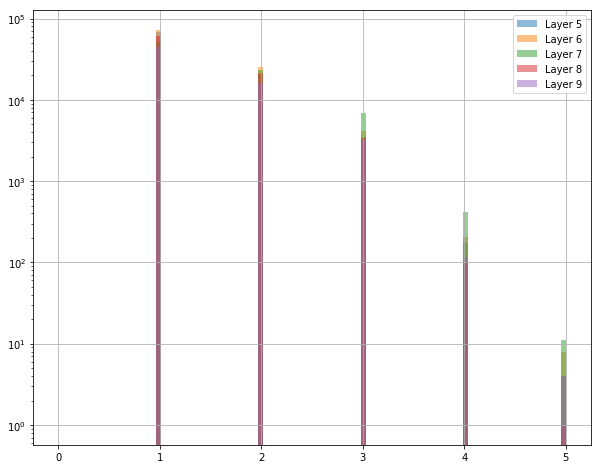

In [195]:
plt.figure(figsize = (10,8))

xbins = np.linspace(0,5,100)

for layer in range(5,10):
    
    label = 'nhits_l%i' %layer
    
    sel = df_lays[label] < 9
    sel &= df_lays.nhits > 1

    r = plt.hist((df_lays[label])[sel], xbins, label = 'Layer %i' %layer,
                 alpha = 0.5)
    
plt.yscale('log')
plt.legend()
plt.grid()

In [192]:
sel = df_lays.nhits_l5 < 9
r = plt.hist(df_lays.nhits_l5[sel], 50)

In [104]:
sel = df_lays.ene_l5 < 500
r = plt.hist2d(df_lays.nhit_l5[sel], df_lays.ene_l5[sel], (8,50), norm = LogNorm())

In [107]:
sel = df_lays.nhit_l5 > 3

plt.hist2d(df_lays[sel].ene_l5, df_lays[sel].time_l5, 100)
plt.show()

In [81]:
sel = df_lays.time_l8 > 0
sel &= df_lays.time_l9 > 0

plt.hist2d(df_lays[sel].time_l8, df_lays[sel].time_l9, 100)
plt.show()

In [153]:
sel = df_lays.time_corr_l8 > 0
sel &= df_lays.time_corr_l9 > 0

plt.hist2d(df_lays[sel].time_corr_l8, df_lays[sel].time_corr_l9, 100)
plt.show()

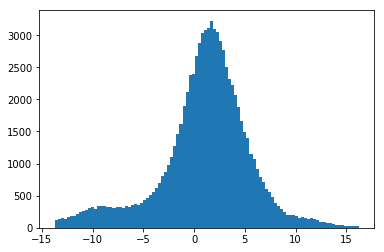

4.528859435527782


In [70]:
sel = df_lays.time_l8 > 0
sel &= df_lays.time_l9 > 0

dt = df_lays.time_l8 - df_lays.time_l9
sel &= abs(dt-dt.median()) < 15
plt.hist(dt[sel], 100)

print dt[sel].std()
plt.show()

In [177]:
labels = [ u'time_corr', u'time_corr_l5', u'time_corr_l6', u'time_corr_l7', u'time_corr_l8', u'time_corr_l9']
df_lays[labels].corr()

time_corr  time_corr_l5  time_corr_l6  time_corr_l7  \
time_corr      1.000000      0.791279      0.677444      0.766313   
time_corr_l5   0.791279      1.000000      0.482766      0.535833   
time_corr_l6   0.677444      0.482766      1.000000      0.409213   
time_corr_l7   0.766313      0.535833      0.409213      1.000000   
time_corr_l8   0.762255      0.499765      0.521002      0.544959   
time_corr_l9   0.715887      0.457840      0.300860      0.532859   

              time_corr_l8  time_corr_l9  
time_corr         0.762255      0.715887  
time_corr_l5      0.499765      0.457840  
time_corr_l6      0.521002      0.300860  
time_corr_l7      0.544959      0.532859  
time_corr_l8      1.000000      0.457430  
time_corr_l9      0.457430      1.000000

In [178]:
labels = [ u'time_corr', u'time_corr_l5', u'time_corr_l6', u'time_corr_l7', u'time_corr_l8', u'time_corr_l9']
df_time = df_lays[labels].dropna()

In [179]:
sns.pairplot(df_time)

2.938626658964937
2.707857681709569


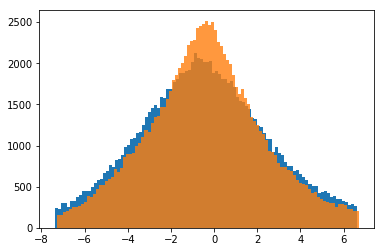

In [169]:
sel = df_lays.time_l5 > 0
sel &= df_lays.time_l6 > 0

dt = df_lays.time_l5 - df_lays.time_l6
sel &= abs(dt-dt.median()) < 7
plt.hist(dt[sel], 100)
print dt[sel].std()

sel = df_lays.time_corr_l5 > 0
sel &= df_lays.time_corr_l6 > 0

dt = df_lays.time_corr_l5 - df_lays.time_corr_l6
sel &= abs(dt-dt.median()) < 7
plt.hist(dt[sel], 100, alpha = 0.8)

print dt[sel].std()

plt.show()

In [170]:
sel = df_lays.time_l8 > 0
sel &= df_lays.time_l9 > 0

dt = df_lays.time_l8 - df_lays.time_l9
sel &= abs(dt-dt.median()) < 7
plt.hist(dt[sel], 100)
print dt[sel].std()

sel = df_lays.time_corr_l8 > 0
sel &= df_lays.time_corr_l9 > 0

dt = df_lays.time_corr_l8 - df_lays.time_corr_l9
sel &= abs(dt-dt.median()) < 7
plt.hist(dt[sel], 100, alpha = 0.8)

print dt[sel].std()

plt.show()

2.8614030786241367
2.703786399503267


In [185]:
sel = df_lays.time_corr_l5 > 0
sel &= df_lays.time_corr_l6 > 0

dt = df_lays.time_corr_l5 - df_lays.time_corr_l6
sel &= abs(dt-dt.median()) < 15
plt.hist(dt[sel]-dt.median(), 100, alpha = 0.8)

print dt[sel].std()

sel &= df_lays.time_corr_l8 > 0
sel &= df_lays.time_corr_l9 > 0

dt = df_lays.time_corr_l8 - df_lays.time_corr_l9
#sel &= abs(dt-dt.median()) < 7
plt.hist(dt[sel]-dt.median(), 100, alpha = 0.8)

plt.show()

4.265315150165382


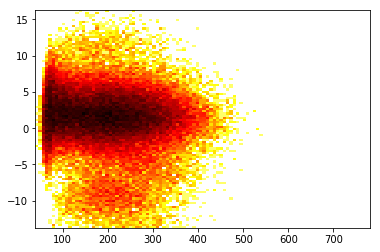

4.528859435527782


In [161]:
sel = df_lays.time_l8 > 0
sel &= df_lays.time_l9 > 0

dt = df_lays.time_l8 - df_lays.time_l9
de = df_lays.ene_l8 + df_lays.ene_l9

sel &= abs(dt-dt.median()) < 15

plt.hist2d(de[sel], dt[sel], 100, norm = LogNorm())
plt.show()

print dt[sel].std()

In [162]:
plt.hist2d(df_lays[sel].time_l8, df_lays[sel].time_l9, 100)
plt.show()